In [ ]:
!pip install pulp

     |████████████████████████████████| 40.6MB 95kB/s 


In [ ]:
import numbers
import numpy as np
import pulp
import itertools
import matplotlib.pyplot as plt
% matplotlib inline


class OptimalTransport:

    def __init__(self):
        pass

    def set_axes_projections(self, *, mu_x, mu_y, mu_z,
                             x_points=None, y_points=None, z_points=None):
        mu_x = np.array(mu_x)
        assert(len(mu_x.shape) == 1)
        assert(np.all(mu_x >= 0))
        mu_y = np.array(mu_y)
        assert(len(mu_y.shape) == 1)
        assert(np.all(mu_y >= 0))
        mu_z = np.array(mu_z)
        assert(len(mu_z.shape) == 1)
        assert(np.all(mu_z >= 0))

        assert np.isclose(mu_x.sum(), mu_y.sum(), 1e-9, 1e-9)
        assert np.isclose(mu_y.sum(), mu_z.sum(), 1e-9, 1e-9)
        self.total_measure_ = mu_x.sum()

        self.x_points_ = x_points if x_points is not None else np.arange(len(mu_x))
        self.y_points_ = y_points if y_points is not None else np.arange(len(mu_y))
        self.z_points_ = z_points if z_points is not None else np.arange(len(mu_z))

        self.x_range_ = np.arange(len(mu_x))
        self.y_range_ = np.arange(len(mu_y))
        self.z_range_ = np.arange(len(mu_z))

        self.mu_xy_ = mu_x[..., np.newaxis] * mu_y[np.newaxis, ...] / self.total_measure_
        self.mu_xz_ = mu_x[..., np.newaxis] * mu_z[np.newaxis, ...] / self.total_measure_
        self.mu_yz_ = mu_y[..., np.newaxis] * mu_z[np.newaxis, ...] / self.total_measure_
        self.uniting_measure_ = mu_x[:, np.newaxis, np.newaxis] * mu_y[np.newaxis, :, np.newaxis] * mu_z[np.newaxis, np.newaxis, :]
        self.uniting_measure_ /= self.total_measure_ ** 2

    def set_plane_projections(self, *, mu_xy, mu_xz, mu_yz,
                             x_points=None, y_points=None, z_points=None):
        mu_xy = np.array(mu_xy)
        assert(len(mu_xy.shape) == 2)
        assert(np.all(mu_xy >= 0))

        mu_xz = np.array(mu_xz)
        assert(len(mu_xz.shape) == 2)
        assert(np.all(mu_xz >= 0))

        mu_yz = np.array(mu_yz)
        assert(len(mu_yz.shape) == 2)
        assert(np.all(mu_yz >= 0))

        assert np.allclose(mu_xy.sum(axis=1), mu_xz.sum(axis=1), 1e-9, 1e-9)
        assert np.allclose(mu_xy.sum(axis=0), mu_yz.sum(axis=1), 1e-9, 1e-9)
        assert np.allclose(mu_xz.sum(axis=0), mu_yz.sum(axis=0), 1e-9, 1e-9)

        self.total_measure_ = mu_xy.sum()

        self.x_points_ = x_points if x_points is not None else np.arange(mu_xy.shape[0])
        self.y_points_ = y_points if y_points is not None else np.arange(mu_xy.shape[1])
        self.z_points_ = z_points if z_points is not None else np.arange(mu_yz.shape[1])

        self.x_range_ = np.arange(mu_xy.shape[0])
        self.y_range_ = np.arange(mu_xy.shape[1])
        self.z_range_ = np.arange(mu_yz.shape[1])

        self.mu_xy_ = mu_xy
        self.mu_xz_ = mu_xz
        self.mu_yz_ = mu_yz

        self.uniting_measure_ = None

    def set_cost_function(self, cost_function):
        if callable(cost_function):
            self.cost_function_ = np.array([[[
                cost_function(x, y, z)
                for z in self.z_points_]
                for y in self.y_points_]
                for x in self.x_points_]
            )
        else:
            self.cost_function_ = np.array(cost_function)
            assert(
                self.cost_function_.shape ==
                (len(self.x_points_), len(self.y_points_), len(self.z_points_))
            )

    def is_symmetric(self, check_cost_function=True):
        is_symmetric = np.array_equal(self.x_points_, self.y_points_)
        is_symmetric = is_symmetric and np.array_equal(self.x_points_, self.z_points_)

        if not check_cost_function:
            return is_symmetric

        for perm in itertools.permutations(list(range(3))):
            is_symmetric = is_symmetric and np.all(np.isclose(self.cost_function_, self.cost_function_.transpose(perm), 1e-9, 1e-9))
        return is_symmetric

    def prepare_primal_problem_(self, check_cost_function):
        problem = pulp.LpProblem('primal_problem', pulp.LpMinimize)
        measure = self.measure_wrapper_(check_cost_function=check_cost_function)

        pr_xy = {
            item: 0 for item in itertools.product(self.x_range_, self.y_range_)
        }
        pr_xz = {
            item: 0 for item in itertools.product(self.x_range_, self.z_range_)
        }
        pr_yz = {
            item: 0 for item in itertools.product(self.y_range_, self.z_range_)
        }

        for (i, j, k) in itertools.product(self.x_range_, self.y_range_, self.z_range_):
            pr_xy[(i, j)] += measure(i, j, k)
            pr_xz[(i, k)] += measure(i, j, k)
            pr_yz[(j, k)] += measure(i, j, k)
        for (i, j) in itertools.product(self.x_range_, self.y_range_):
            problem += pr_xy[(i, j)] == self.mu_xy_[i, j]
        for (i, k) in itertools.product(self.x_range_, self.z_range_):
            problem += pr_xz[(i, k)] == self.mu_xz_[i, k]
        for (j, k) in itertools.product(self.y_range_, self.z_range_):
            problem += pr_yz[(j, k)] == self.mu_yz_[j, k]
        return problem, measure

    def get_measure_array_(self, measure):
        measure_array = np.array([[[
            pulp.value(measure(i, j, k))
            for k in self.z_range_]
            for j in self.y_range_]
            for i in self.x_range_]
        )
        return measure_array

    def get_dual_array_(self, f, g, h):
        f_array = np.array([[
            pulp.value(f(i, j))
            for j in self.y_range_]
            for i in self.x_range_]
        )
        g_array = np.array([[
            pulp.value(g(i, k))
            for k in self.z_range_]
            for i in self.x_range_]
        )
        h_array = np.array([[
            pulp.value(h(j, k))
            for k in self.z_range_]
            for j in self.y_range_]
        )
        return f_array, g_array, h_array

    def find_uniting_measure(self):
        if self.uniting_measure_:
            return self.uniting_measure_
        problem, measure = self.prepare_primal_problem_(check_cost_function=True)
        problem += 0
        assert pulp.LpStatus[problem.solve()] == 'Optimal', pulp.LpStatus[problem.solve()]
        return self.get_measure_array_(measure)

    def find_primal_solution(self):
        problem, measure = self.prepare_primal_problem_(check_cost_function=True)
        obj = 0
        for (i, j, k) in itertools.product(self.x_range_, self.y_range_, self.z_range_):
            obj += self.cost_function_[i, j, k] * measure(i, j, k)
        problem += obj
        assert pulp.LpStatus[problem.solve()] == 'Optimal', pulp.LpStatus[problem.solve()]
        return pulp.value(obj), self.get_measure_array_(measure)

    def find_major_primal_solution(self, less=True):
        problem = pulp.LpProblem('primal_problem', pulp.LpMinimize)
        measure = self.measure_wrapper_(check_cost_function=True)
        pr_xy = {
            item: 0 for item in itertools.product(self.x_range_, self.y_range_)
        }
        pr_xz = {
            item: 0 for item in itertools.product(self.x_range_, self.z_range_)
        }
        pr_yz = {
            item: 0 for item in itertools.product(self.y_range_, self.z_range_)
        }
        for (i, j, k) in itertools.product(self.x_range_, self.y_range_, self.z_range_):
            pr_xy[(i, j)] += measure(i, j, k)
            pr_xz[(i, k)] += measure(i, j, k)
            pr_yz[(j, k)] += measure(i, j, k)

        for (i, j) in itertools.product(self.x_range_, self.y_range_):
            S = 0
            mu_s = 0
            for (u, v) in itertools.product(list(range(i + 1)), list(range(j + 1))):
                S += pr_xy[(u, v)]
                mu_s += self.mu_xy_[u, v]
            if less and i < self.x_range_[-1] and j < self.y_range_[-1]:
                problem += S <= mu_s
            elif not less and i < self.x_range_[-1] and j < self.y_range_[-1]:
                problem += S >= mu_s
            else:
                problem += S == mu_s
        for (i, k) in itertools.product(self.x_range_, self.z_range_):
            S = 0
            mu_s = 0
            for (u, v) in itertools.product(list(range(i + 1)), list(range(k + 1))):
                S += pr_xz[(u, v)]
                mu_s += self.mu_xz_[u, v]
            if less and i < self.x_range_[-1] and k < self.z_range_[-1]:
                problem += S <= mu_s
            elif not less and i < self.x_range_[-1] and k < self.z_range_[-1]:
                problem += S >= mu_s
            else:
                problem += S == mu_s
        for (j, k) in itertools.product(self.y_range_, self.z_range_):
            S = 0
            mu_s = 0
            for (u, v) in itertools.product(list(range(j + 1)), list(range(k + 1))):
                S += pr_yz[(u, v)]
                mu_s += self.mu_yz_[u, v]
            if less and j < self.y_range_[-1] and k < self.z_range_[-1]:
                problem += S <= mu_s
            elif not less and j < self.y_range_[-1] and k < self.z_range_[-1]:
                problem += S >= mu_s
            else:
                problem += S == mu_s
        obj = 0
        for (i, j, k) in itertools.product(self.x_range_, self.y_range_, self.z_range_):
            obj += self.cost_function_[i, j, k] * measure(i, j, k)
        problem += obj
        assert pulp.LpStatus[problem.solve()] == 'Optimal', pulp.LpStatus[problem.solve()]
        return pulp.value(obj), self.get_measure_array_(measure)

    def prepare_dual_problem_(self):
        problem = pulp.LpProblem('dual_problem', pulp.LpMaximize)
        f, g, h = self.dual_wrapper_()
        for (i, j, k) in itertools.product(self.x_range_, self.y_range_, self.z_range_):
            problem += f(i, j) + g(i, k) + h(j, k) <= self.cost_function_[i, j, k]
        obj = 0
        for (i, j) in itertools.product(self.x_range_, self.y_range_):
            obj += f(i, j) * self.mu_xy_[i, j]
        for (i, k) in itertools.product(self.x_range_, self.z_range_):
            obj += g(i, k) * self.mu_xz_[i, k]
        for (j, k) in itertools.product(self.y_range_, self.z_range_):
            obj += h(j, k) * self.mu_yz_[j, k]
        problem += obj
        return problem, f, g, h, obj

    def find_dual_solution(self):
        problem, f, g, h, obj = self.prepare_dual_problem_()
        assert pulp.LpStatus[problem.solve()] == 'Optimal', pulp.LpStatus[problem.solve()]
        f_array, g_array, h_array = self.get_dual_array_(f, g, h)
        return pulp.value(obj), f_array, g_array, h_array

    def find_major_dual_solution(self, less=True):
        problem, f, g, h, obj = self.prepare_dual_problem_()

        def sign(a, b, sign):
            if sign:
                return a <= b
            else:
                return a >= b

        for (i, j) in itertools.product(self.x_range_[:-1], self.y_range_[:-1]):
            problem += sign(f(i + 1, j + 1) + f(i, j), f(i + 1, j) + f(i, j + 1), less)
        for (i, k) in itertools.product(self.x_range_[:-1], self.z_range_[:-1]):
            problem += sign(g(i + 1, k + 1) + g(i, k), g(i + 1, k) + g(i, k + 1), less)
        for (j, k) in itertools.product(self.y_range_[:-1], self.z_range_[:-1]):
            problem += sign(h(j + 1, k + 1) + h(j, k), h(j + 1, k) + h(j, k + 1), less)
        assert pulp.LpStatus[problem.solve()] == 'Optimal', pulp.LpStatus[problem.solve()]
        f_array, g_array, h_array = self.get_dual_array_(f, g, h)
        return pulp.value(obj), f_array, g_array, h_array

    def dual_wrapper_(self):
        if self.is_symmetric(check_cost_function=True):
            f = {
                (i, j): pulp.LpVariable('f_{}_{}'.format(i, j), None, None)
                for (i, j) in itertools.product(self.x_range_, self.y_range_)
                if i <= j
            }
            def dual(i, j):
                i, j = sorted((i, j))
                return f[(i, j)]
            return dual, dual, dual

        f = pulp.LpVariable.dict('f', (list(self.x_range_), list(self.y_range_)), None, None)
        def f_callable(i, j):
            return f[(i, j)]

        g = pulp.LpVariable.dict('g', (list(self.x_range_), list(self.z_range_)), None, None)
        def g_callable(i, k):
            return g[(i, k)]

        h = pulp.LpVariable.dict('h', (list(self.y_range_), list(self.z_range_)), None, None)
        def h_callable(j, k):
            return h[(j, k)]
        return f_callable, g_callable, h_callable

    def measure_wrapper_(self, check_cost_function):
        if self.is_symmetric(check_cost_function=check_cost_function):
            measure_impl = {
                (i, j, k) : pulp.LpVariable('measure_{}_{}_{}'.format(i, j, k), 0, None)
                for (i, j, k) in itertools.product(self.x_range_, self.y_range_, self.z_range_)
                if i <= j <= k
            }
            def measure(i, j, k):
                return measure_impl[tuple(sorted((i, j, k)))]
            return measure

        measure_impl = pulp.LpVariable.dict(
            'measure',
            (list(self.x_range_), list(self.y_range_), list(self.z_range_)),
            0, None,
        )
        def measure(i, j, k):
            return measure_impl[(i, j, k)]
        return measure


In [ ]:
def generate_frame_functions(f, g, h, point=None):
    if point is None:
        point = (0, 0, 0)
    F = f[..., np.newaxis] + g[:, np.newaxis, :] + h[np.newaxis, ...]
    f0 = F[..., point[2]] - 1 / 2 * (F[:, point[1], point[2]] + F[point[0], :, point[2]]) + 1 / 3 * F[point[0], point[1], point[2]]
    g0 = F[:, point[1], :] - 1 / 2 * (F[point[0], point[1], :] + F[:, point[1], point[2]]) + 1 / 3 * F[point[0], point[1], point[2]]
    h0 = F[point[0], ...] - 1 / 2 * (F[point[0], point[1], :] + F[point[0], :, point[2]]) + 1 / 3 * F[point[0], point[1], point[2]]
    F0 = f0[..., np.newaxis] + g0[:, np.newaxis, :] + h0[np.newaxis, ...]
    print(F, F0)
    assert(np.all(np.isclose(F0, F)))
    return f0, g0, h0

Решим, используя данную библиотеку, прямую и двойственную задачу для функции стоимости $xyz$. Задача с доминированием решается почему-то дольше задачи без него, имеет смысл для проверки брать малую частоту дискретизации

In [ ]:
%%time
size = 64
problem = OptimalTransport()
import scipy.stats
xs = np.array([scipy.stats.norm.ppf(i / (size + 1)) for i in range(1, size + 1)])
# xs = np.linspace(-4, 4, size)
mu = scipy.stats.norm.cdf(xs)
mu[1:] = mu[1:] - mu[:-1]
problem.set_axes_projections(
    mu_x=mu, # равномерные вероятностные меры на точках (0, 1, ..., size - 1)
    mu_y=mu,
    mu_z=mu,
    x_points=xs,
    y_points=xs,
    z_points=xs,
)
problem.set_cost_function(
    lambda i, j, k: i * j * k # передаем функцию стоимости, которая на вход принимает точки соответствующих пространств
)
primal_cost, measure = problem.find_primal_solution()
print('Ответ в прямой задаче: ', primal_cost)

Ответ в прямой задаче:  -0.5509044555286104
CPU times: user 17.1 s, sys: 192 ms, total: 17.3 s
Wall time: 1min 6s


In [ ]:
dual_cost, f, g, h = problem.find_dual_solution()
print('Ответ в прямой задаче: ', dual_cost)

Ответ в прямой задаче:  -0.5509044517912038


In [ ]:
size = 64
problem = OptimalTransport()
xs = np.linspace(0, 1, size)
mu = np.arange(1, size + 1, dtype=np.float)
mu /= mu.sum()
problem.set_axes_projections(
    mu_x=mu, # равномерные вероятностные меры на точках (0, 1, ..., size - 1)
    mu_y=mu,
    mu_z=mu,
    x_points=xs,
    y_points=xs,
    z_points=xs,
)
problem.set_cost_function(
    lambda i, j, k: i * j * k # передаем функцию стоимости, которая на вход принимает точки соответствующих пространств
)
primal_cost, f, g, h = problem.find_dual_solution()
print('Ответ в прямой задаче: ', primal_cost)

Ответ в прямой задаче:  0.28678140784567413


In [ ]:
primal_cost, measure = problem.find_primal_solution()
print('Ответ в прямой задаче: ', primal_cost)

Ответ в прямой задаче:  0.2867813757393224


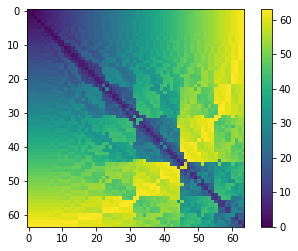

In [ ]:
delta_f = f[1:, 1:] + f[:-1, :-1] - f[1:, :-1] - f[:-1, 1:]
mu_xy = mu[:, np.newaxis] * mu[np.newaxis, :]
delta_mu = mu_xy[1:, 1:] + mu_xy[:-1, :-1] - mu_xy[1:, :-1] - mu_xy[:-1, 1:]
plt.imshow(np.argmax(measure, axis=0))
plt.colorbar()


In [ ]:
size = 64
problem = OptimalTransport()
import scipy.stats
xs = np.array([scipy.stats.norm.ppf(i / (size + 1)) for i in range(1, size + 1)])
# xs = np.linspace(-4, 4, size)
mu = scipy.stats.norm.cdf(xs)
mu[1:] = mu[1:] - mu[:-1]
problem.set_axes_projections(
    mu_x=mu, # равномерные вероятностные меры на точках (0, 1, ..., size - 1)
    mu_y=mu,
    mu_z=mu,
    x_points=xs,
    y_points=xs,
    z_points=xs,
)
problem.set_cost_function(
    lambda i, j, k: i * j * k # передаем функцию стоимости, которая на вход принимает точки соответствующих пространств
)
primal_cost, f, g, h = problem.find_dual_solution()
print('Ответ в прямой задаче: ', primal_cost)

KeyboardInterrupt: ignored

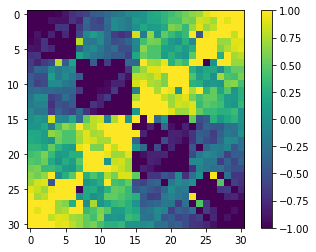

In [ ]:
gf = g
xs_2d = xs[1:] - xs[:-1]
xs_2d = xs_2d[:, np.newaxis] * xs_2d[np.newaxis, :]
t = (gf[1:, 1:] + gf[:-1, :-1] - gf[1:, :-1] - gf[:-1, 1:]) / xs_2d
t[np.where(t > 1)] = 1
t[np.where(t < -1)] = -1

plt.imshow(t)
plt.colorbar()

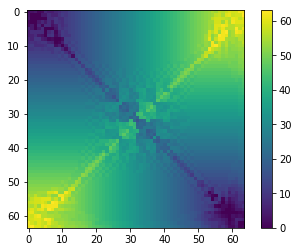

In [ ]:
plt.imshow(np.argmax(measure, axis=1))
plt.colorbar()

In [ ]:
xs

array([-4.15888308, -3.44998755, -3.0285221 , -2.7245795 , -2.48490665,
       -2.28577797, -2.11453286, -1.96360973, -1.82812711, -1.70474809,
       -1.59108877, -1.48538526, -1.38629436, -1.2927683 , -1.2039728 ,
       -1.11923158, -1.03798767, -0.95977584, -0.88420242, -0.81093022,
       -0.7396672 , -0.67015766, -0.6021754 , -0.53551824, -0.47000363,
       -0.40546511, -0.34174929, -0.2787134 , -0.21622311, -0.15415068,
       -0.09237332, -0.03077166,  0.03077166,  0.09237332,  0.15415068,
        0.21622311,  0.2787134 ,  0.34174929,  0.40546511,  0.47000363,
        0.53551824,  0.6021754 ,  0.67015766,  0.7396672 ,  0.81093022,
        0.88420242,  0.95977584,  1.03798767,  1.11923158,  1.2039728 ,
        1.2927683 ,  1.38629436,  1.48538526,  1.59108877,  1.70474809,
        1.82812711,  1.96360973,  2.11453286,  2.28577797,  2.48490665,
        2.7245795 ,  3.0285221 ,  3.44998755,  4.15888308])

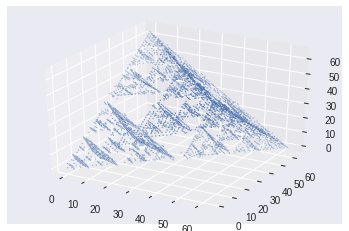

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

px = []
py = []
pz = []
for i, j, k in itertools.product(range(64), repeat=3):
    if measure[i, j, k] > 1e-4:
        px.append(i)
        py.append(j)
        pz.append(k)
ax.scatter3D(px, py, pz, s=1)

Теперь для случая, если надо задать свои точки на осях. Здесь будет 3 точки на оси $z$

In [ ]:
%%time
size = 40
problem = OptimalTransport()
problem.set_axes_projections(
    mu_x=np.ones(size) / size, # равномерные вероятностные меры на точках (0, 1, ..., size - 1)
    mu_y=np.ones(size) / size,
    mu_z=np.ones(3) / 3,
    x_points=np.linspace(0, 1, size), # эта команда задает size точек на равном расстоянии на отрезке [0, 1],
    y_points=np.linspace(0, 1, size),
    z_points=(0, 1, 2) # или list(range(3)), или np.arange(3)
)
problem.set_cost_function(
    lambda i, j, k: (i * j * k) ** 0.5 # передаем функцию стоимости, которая на вход принимает точки соответствующих пространств
)
primal_cost, measure = problem.find_primal_solution()
print('Ответ в прямой задаче: ', primal_cost)

# Здесь решаем задачу с мажорированием. Она решается дольше прямой
# less может быть True или False. Примерно так: если поменяли знак у функции стоимости, то и less надо понять на противоположный
primal_major_cost, measure = problem.find_major_primal_solution(less=False)
print('Ответ в задаче с мажорированием: ', primal_major_cost)


Ответ в прямой задаче:  0.3287891569522148
Ответ в задаче с мажорированием:  0.3287682051516217
CPU times: user 20.7 s, sys: 322 ms, total: 21.1 s
Wall time: 27.5 s


Тут, например, видно, что ответы примерно совпадают (совсем совпадать они и не должны)

А ещё можно задать не только равномерную меру.
Главное, чтобы суммарная мера каждого из пространств была одинаковой

In [ ]:
%%time
size = 60
problem = OptimalTransport()
problem.set_axes_projections(
    mu_x=np.ones(size) / size, # равномерные вероятностные меры на точках (0, 1, ..., size - 1)
    mu_y=np.ones(size) / size,
    mu_z=(2/3, 1/3), # задаем меру на z
    x_points=np.linspace(0, 1, size), # эта команда задает size точек на равном расстоянии на отрезке [0, 1],
    y_points=np.linspace(0, 1, size),
    z_points=(0, 1) # и точки на z
)
problem.set_cost_function(
    lambda i, j, k: i * j * k # передаем функцию стоимости, которая на вход принимает точки соответствующих пространств
)
primal_cost, measure = problem.find_primal_solution()
print('Ответ в прямой задаче: ', primal_cost)

# Здесь решаем задачу с мажорированием. Она решается дольше прямой
# less может быть True или False. Примерно так: если поменяли знак у функции стоимости, то и less надо понять на противоположный
primal_major_cost, major_measure = problem.find_major_primal_solution(less=False)
print('Ответ в задаче с мажорированием: ', primal_major_cost)


Ответ в прямой задаче:  0.05736601916364265
Ответ в задаче с мажорированием:  0.056736570405105324
CPU times: user 1min 19s, sys: 1.42 s, total: 1min 20s
Wall time: 1min 33s


Можно, например, визуализировать построенную меру с помощью команды plt.imshow

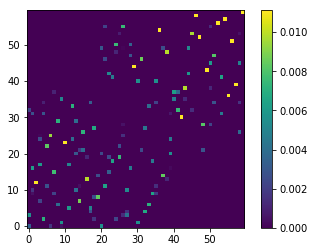

In [ ]:
plt.imshow(major_measure[..., 0], origin='lower') # слой z = 0
plt.colorbar()
plt.grid(False) # убираем сетку
plt.show()

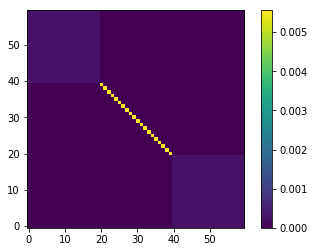

In [ ]:
plt.imshow(major_measure[..., 1], origin='lower') # слой z = 1
plt.colorbar()
plt.grid(False) # убираем сетку
plt.show()

Это была визуализация для доминирования для 2 точек с весами 2/3, 1/3. Ничего похожего на "гусеницы" не видно. Для сравнения, визуализация без доминирования:

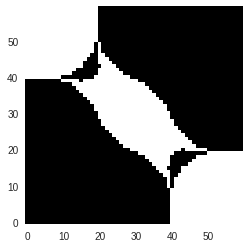

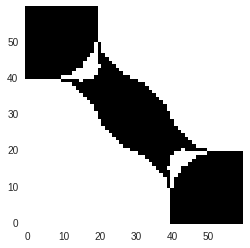

In [ ]:
plt.imshow(measure[..., 0], origin='lower') # слой z = 0
plt.grid(False) # убираем сетку
plt.show()
plt.imshow(measure[..., 1], origin='lower') # слой z = 1
plt.grid(False) # убираем сетку
plt.show()

Хм, а что если посмотреть на случай 3 точек на оси z?

Ответ в задаче с мажорированием:  0.20033754809109913


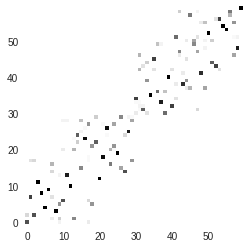

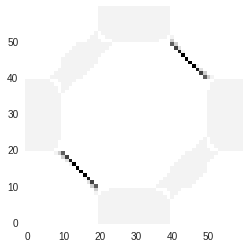

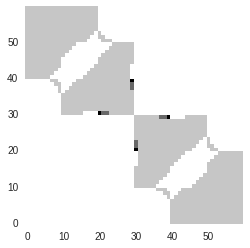

CPU times: user 2min 24s, sys: 1.79 s, total: 2min 26s
Wall time: 3min 21s


In [ ]:
%%time
size = 60
problem = OptimalTransport()
problem.set_axes_projections(
    mu_x=np.ones(size) / size, # равномерные вероятностные меры на точках (0, 1, ..., size - 1)
    mu_y=np.ones(size) / size,
    mu_z=np.ones(3) / 3, # задаем меру на z
    x_points=np.linspace(0, 1, size), # эта команда задает size точек на равном расстоянии на отрезке [0, 1],
    y_points=np.linspace(0, 1, size),
    z_points=(0, 1, 2) # и точки на z
)
problem.set_cost_function(
    lambda i, j, k: i * j * k # передаем функцию стоимости, которая на вход принимает точки соответствующих пространств
)
primal_major_cost, major_measure = problem.find_major_primal_solution(less=False)
print('Ответ в задаче с мажорированием: ', primal_major_cost)

plt.imshow(major_measure[..., 0], origin='lower') # слой z = 0
plt.grid(False) # убираем сетку
plt.show()
plt.imshow(major_measure[..., 1], origin='lower') # слой z = 1
plt.grid(False) # убираем сетку
plt.show()
plt.imshow(major_measure[..., 2], origin='lower') # слой z = 2
plt.grid(False) # убираем сетку
plt.show()

Кажется, что в дискретном случае нет доминирования

Ещё можно искать двойственные решения, например так:

In [ ]:
dual_major_cost, mf, mg, mh = problem.find_major_dual_solution(less=False)
print('Ответ в задаче с мажорированием: ', dual_major_cost)
dual_cost, f, g, h = problem.find_dual_solution()
print('Ответ в двойственной задаче: ', dual_major_cost)

Ответ в задаче с мажорированием:  0.20033784757589532
Ответ в двойственной задаче:  0.20033784757589532


In [ ]:
%%time
size = 60
problem = OptimalTransport()
problem.set_axes_projections(
    mu_x=np.exp(-np.linspace(0, 4, size)),
    mu_y=np.exp(-np.linspace(0, 4, size)),
    mu_z=np.exp(-np.linspace(0, 4, size))
)
problem.set_cost_function(
    lambda i, j, k: i * j * k # передаем функцию стоимости, которая на вход принимает точки соответствующих пространств
)
primal_cost, measure = problem.find_primal_solution()
print('Ответ в прямой задаче: ', primal_cost)

# Здесь решаем задачу с мажорированием. Она решается дольше прямой
# less может быть True или False. Примерно так: если поменяли знак у функции стоимости, то и less надо понять на противоположный
# primal_major_cost, measure = problem.find_major_primal_solution(less=False)
# print('Ответ в задаче с мажорированием: ', primal_major_cost)


Ответ в прямой задаче:  20027.213569576423
CPU times: user 16.1 s, sys: 244 ms, total: 16.3 s
Wall time: 21.9 s


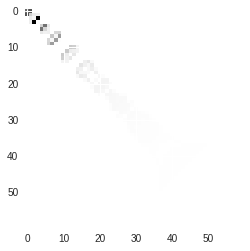

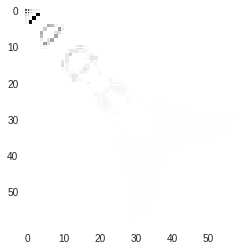

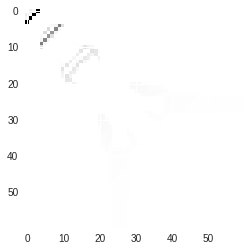

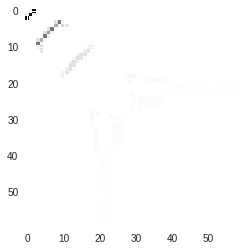

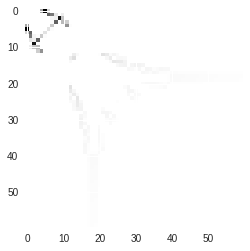

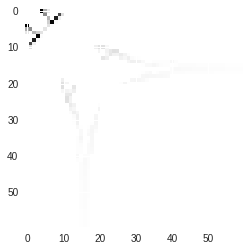

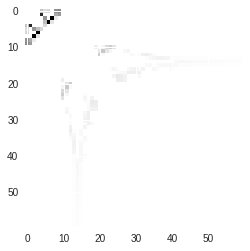

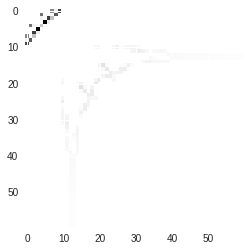

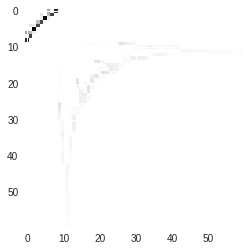

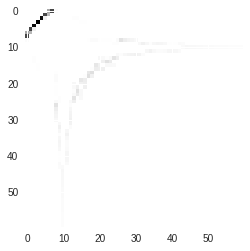

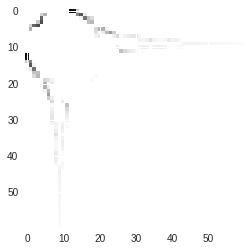

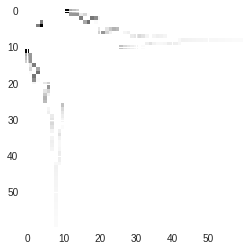

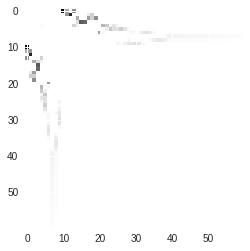

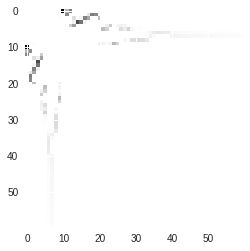

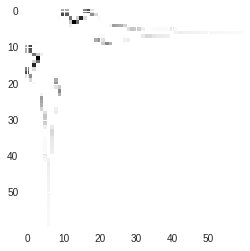

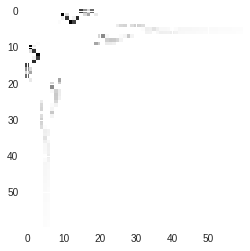

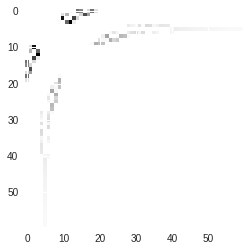

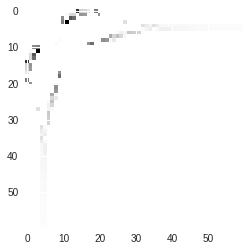

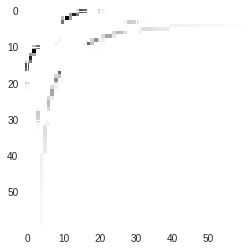

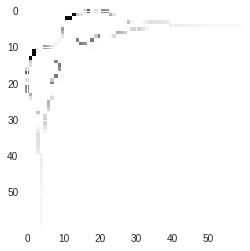

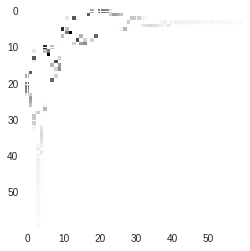

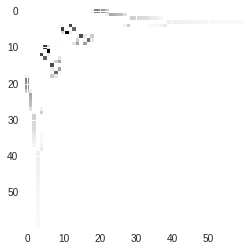

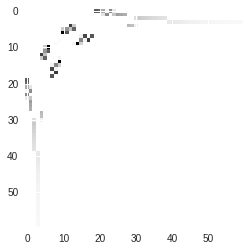

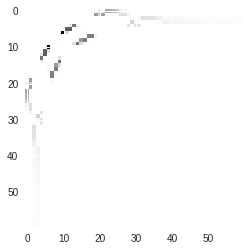

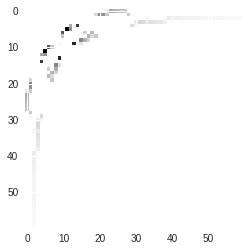

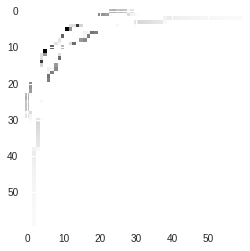

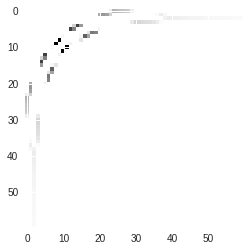

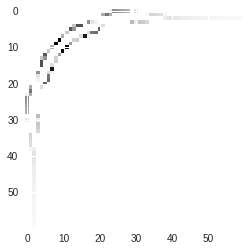

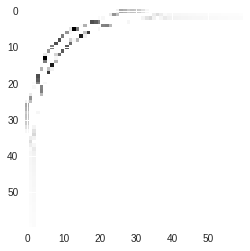

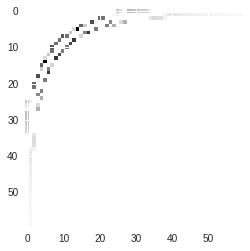

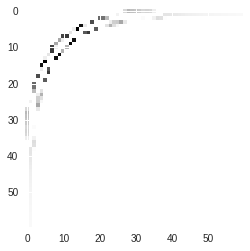

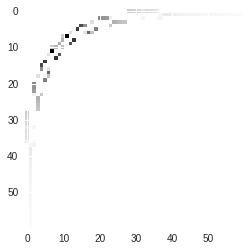

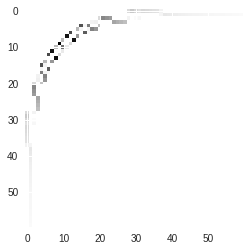

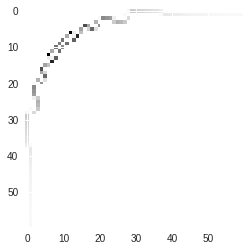

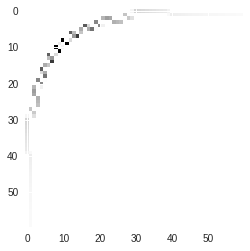

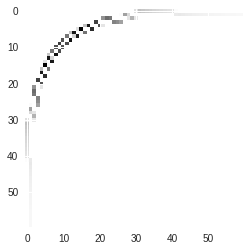

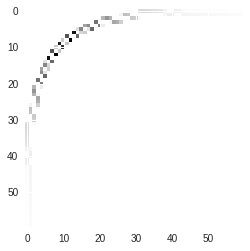

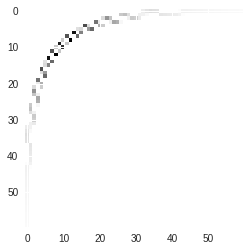

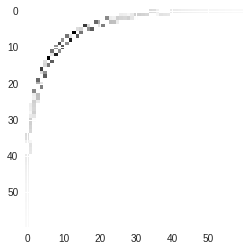

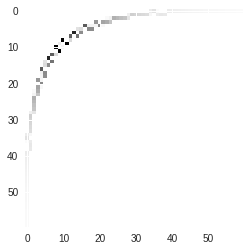

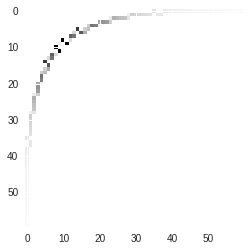

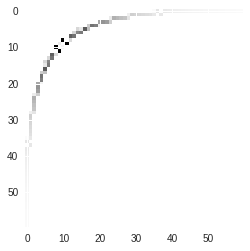

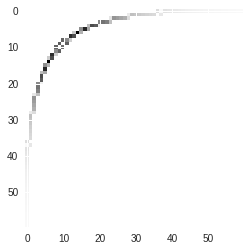

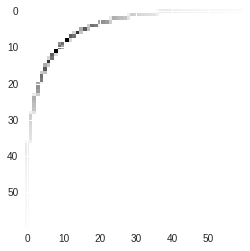

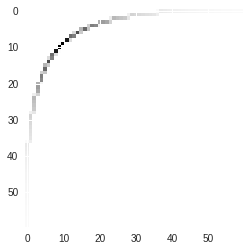

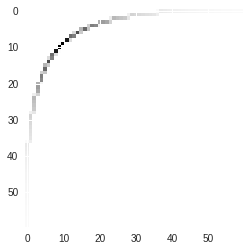

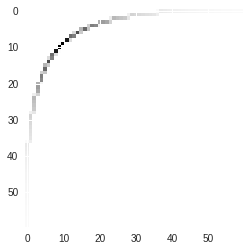

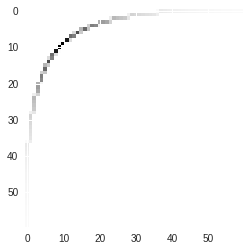

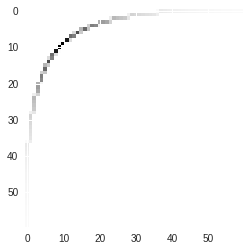

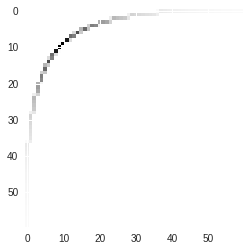

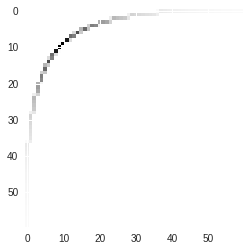

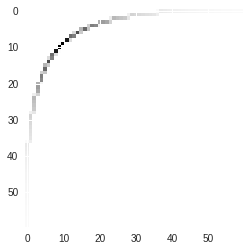

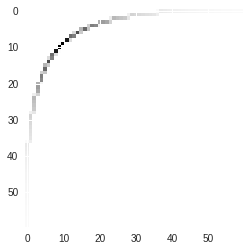

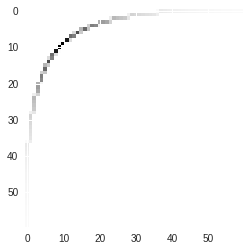

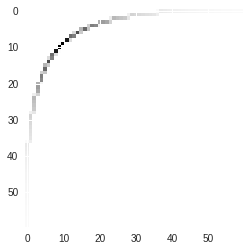

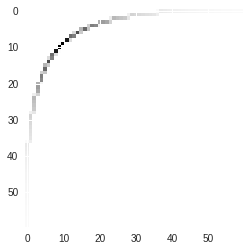

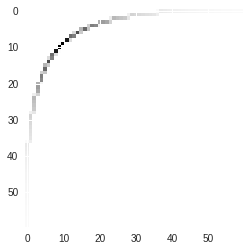

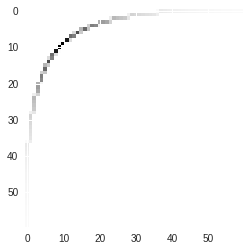

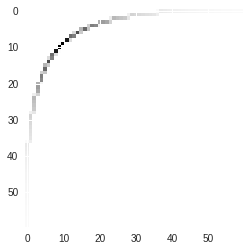

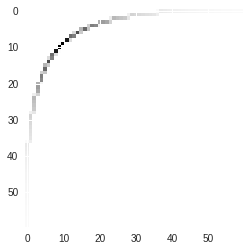

In [ ]:
for i in range(size):
    plt.imshow(measure[..., i])
    plt.show()

In [ ]:
size = 80
proj = np.array([[
    1 if abs(i) + abs(j) <= size // 2 else 0 for j in np.linspace(-size / 2 + 0.5, size/2 - 0.5, size)
] for i in np.linspace(-size / 2 + 0.5, size/2 - 0.5, size)])
problem = OptimalTransport()
problem.set_plane_projections(
    mu_xy=proj,
    mu_xz=proj,
    mu_yz=proj,
    x_points=np.linspace(-1, 1, size),
    y_points=np.linspace(-1, 1, size),
    z_points=np.linspace(-1, 1, size),
)
problem.set_cost_function(lambda x,y,z: x * y * z)

In [ ]:
_, f,g,h = problem.find_dual_solution()

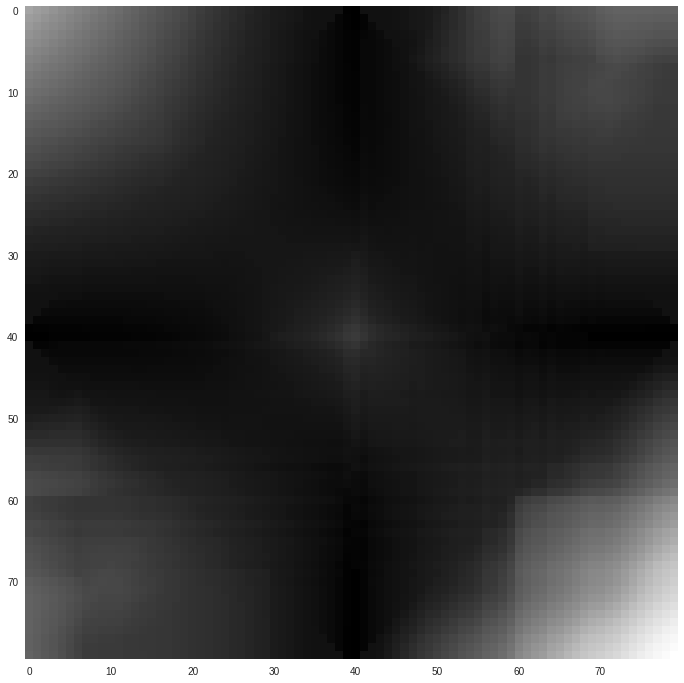

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.imshow(f)
plt.grid(False)
plt.show()

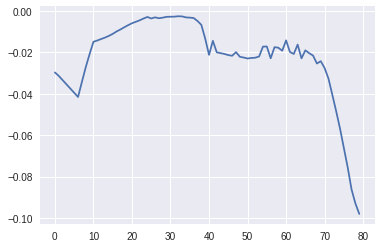

In [ ]:
plt.plot(f[50,:])

In [ ]:
def ggg(x, y):
    return -1 / 36 + 1 / 2 * x * y + 1 / 8 * (x ** 2 +y ** 2) - 1 / 12 *  (x ** 3 + y ** 3) - 1 / 2 * x * y * (x+y)

In [ ]:
def F(x, y):
    return ggg(abs(x), abs(y))

In [ ]:
for x in np.linspace(-1, 1, 101):
    for y in np.linspace(-1, 1, 101):
        for z in np.linspace(-1, 1, 101):
            assert F(x, y) + F(x, z) + F(y, z) <= x * y * z + 1e-2, (x,y,z)

AssertionError: ignored

In [ ]:
s = 0
size = 8192
for i in range(size):
    for j in range(size):
        s += (i * j * (i ^ j) / size ** 3) ** (1 / 3)
s /= size ** 2
s

KeyboardInterrupt: ignored

In [ ]:
size = 8 * 1024
x = np.arange(size, dtype=np.int64)
f = np.bitwise_xor(x[:, np.newaxis] ** 2, x[np.newaxis, :] ** 2).astype(np.float64) ** (1 / 2)
f = np.cumsum(f, axis=0)
f = np.cumsum(f, axis=1)
f /= size ** 2

In [ ]:
res = (x[:, np.newaxis] * x[np.newaxis, :]).astype(np.float64) ** (1 / 2) * np.bitwise_xor(x[:, np.newaxis], x[np.newaxis, :]).astype(np.float64) ** (1 / 2)

In [ ]:
res.sum() / size ** (3.5)

0.28739225519303646

In [ ]:
nf = np.zeros_like(f)
nf[1:, 1:] = f[:-1, :-1]
f = nf / size

In [ ]:
f -= (np.diagonal(f)[:, np.newaxis] + np.diagonal(f)[np.newaxis, :]) / 4

In [ ]:
mu = np.linspace(1 / size, 1, size)
mu /= mu.sum()

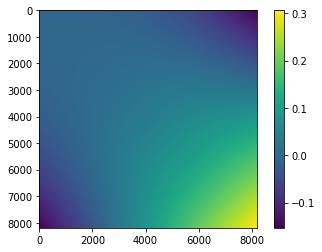

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(f)
plt.colorbar()

In [ ]:
(f * mu[:, np.newaxis] * mu[np.newaxis, :]).sum() * 3 / size

0.2809397189768913

In [ ]:
f /= size


In [ ]:
((768 ** 3) ^ (256 ** 3)) ** (1/3)

758.3989935122866

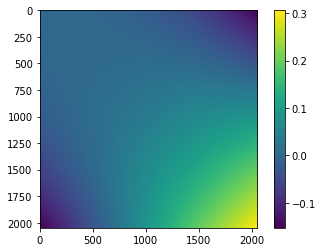

In [ ]:
plt.imshow(f)
plt.colorbar()

In [ ]:
f[1024, 1024]

0.040116712420528326

In [ ]:
res_x = []
res_y = []
res_z = []
for t in range(100000):
    i = np.random.randint(1, size)
    j = np.random.randint(1, size)
    k = np.random.randint(1, size)
    while i < size // 2 and j < size // 2 and k < size // 2:
        i *= 2
        j *= 2
        k *= 2
    k = int(k)

    t = (f[i, j] + f[i, k] + f[j, k]) / (i * j * k / size ** 3)
    if t > 0.999:
        # print(t, (i, j, k), ((i ** 2) ^ (j ** 2) ^ (k ** 2)) / size ** 2)
        res_x.append(i)
        res_y.append(j)
        res_z.append(k)
    res.append(t)

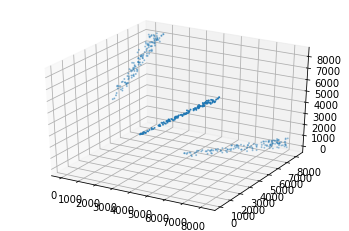

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(res_x, res_y, res_z, s=1)

In [ ]:
0.28 / 0.287

0.9756097560975612